### Exploring the wetsnow dataset with stac and xarray


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pyproj
from pystac_client import Client
from odc.stac import stac_load
import xarray as xr

The pystac_client allows us to explore the data of interest with (or without) a given area and time.

First, we select the dataset, bounding box and datetime.  

In [2]:
collection = "SENTINEL1_ALPS_WETSNOW"

bbox = [6, 47, 7, 48]

date = ['2021-07-28T00:00:00Z', '2021-07-29T00:00:00Z']

The client creates a connection to EODC's stac api and finds data that matches the requested extents.

In [3]:
client = Client.open('https://stac.eodc.eu/api/v1')
results = client.search(collections=collection,
    max_items=10,
    bbox=bbox,
    datetime=date,
)
result_items = list(results.items())
result_items

[<Item id=WSM_ALPS_20210728T054318_E042N018T6_S1B_IW_SLC_027990_004296_00_ENVEO>,
 <Item id=WSM_ALPS_20210728T054318_E042N012T6_S1B_IW_SLC_027990_004296_00_ENVEO>,
 <Item id=WSM_ALPS_20210728T054318_E042N006T6_S1B_IW_SLC_027990_004296_00_ENVEO>]

The stac items contain all the metadata provided, as shown in the example in the next cell:

In [4]:
result_items[0]

<Item id=WSM_ALPS_20210728T054318_E042N018T6_S1B_IW_SLC_027990_004296_00_ENVEO>

We utilize odc's stac_load functionality to load the data as an xarray.DataArray. 

We need to define the coordinate reference system as well as the resolution. As the data is provided in the European Equi7 CRS, we define this accordingly. 

We then select a subset of the data by setting the x and y coordinates.

In [5]:
crs = pyproj.CRS.from_wkt("PROJCS[\"Azimuthal_Equidistant\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0],UNIT[\"degree\",0.0174532925199433],AUTHORITY[\"EPSG\",\"4326\"]],PROJECTION[\"Azimuthal_Equidistant\"],PARAMETER[\"false_easting\",4340913.84808],PARAMETER[\"false_northing\",4812712.92347],PARAMETER[\"longitude_of_center\",94.0],PARAMETER[\"latitude_of_center\",47.0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]]]")
resolution = 200
# crs = pyproj.CRS("epsg:4326")
# resolution = 0.0009

data = stac_load(
    result_items, 
    chunks={"x": 1000, "y": 1000}, 
    bands=["WSM"],
    crs=crs,
    resolution=resolution,
    resampling="nearest",
    )

wsm = data.WSM

wsm_data = wsm.isel(time=0).sel(x=slice(-1308700, -508900), y=slice(8605500, 8135700))

wsm_data

<xarray.DataArray 'WSM' (y: 2291, x: 3942)> Size: 36MB
dask.array<getitem, shape=(2291, 3942), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 18kB 8.596e+06 8.596e+06 ... 8.138e+06 8.138e+06
  * x            (x) float64 32kB -1.309e+06 -1.308e+06 ... -5.205e+05
    spatial_ref  int32 4B 0
    time         datetime64[ns] 8B 2021-07-28T05:43:18

The dataset contains certain discrete values. We use the numpy.unique functionality to list these values: 

In [7]:
unique, counts = np.unique(wsm_data, return_counts=True)

print(unique)

[110. 125. 200. 210. 220.  nan]


The colormap for the dataset was create as defined in the metadata of the files. 

In [8]:
wetsnow_default_color = "0,0,0,255"
wetsow_colors = {
  110: "255,0,255,255",
  115: "246,246,246,255",
  120: "225,230,90,255",
  125: "241,243,109,255",
  200: "40,40,40,255",
  210: "100,100,215,255",
  215: "93,241,244,255",
  220: "25,160,35,255",
  230: "255,190,100,255",
  240: "60,60,60,255",
  255: "0,0,0,0",
}

mpl_colors = []
for cidx in range(0, 256):
    color = wetsow_colors[cidx] if cidx in wetsow_colors else wetsnow_default_color
    r,g,b,t = [int(x.strip())/255.0 for x in color.split(",")]
    mpl_colors.append([r, g, b, t])

wetsnow_cmap = matplotlib.colors.ListedColormap(mpl_colors, name="wetsnow")

Finally, we create a plot of the example dataset on the 28 July, 2021.

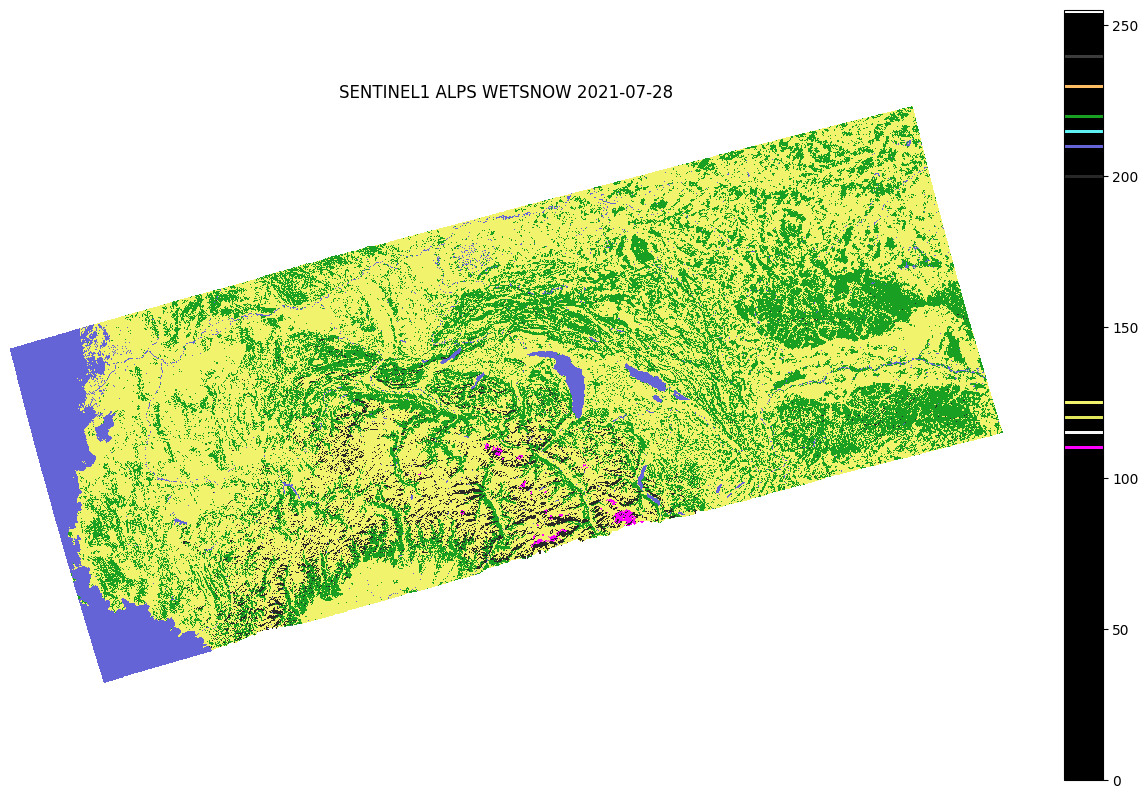

In [9]:
collection_name = collection.replace("_", " ")
time = 0
day = np.datetime64(wsm['time'].values[time], "D")

plt.figure(figsize=(16,10))
plt.imshow(wsm_data, cmap=wetsnow_cmap, vmin=0, vmax=255, interpolation="nearest")
plt.title(f"{collection_name} {day}")
plt.axis("off")
plt.colorbar()
plt.show()